In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Global parameters

In [2]:
# Transparency of Histograms
transp = 0.5

In [3]:
# Set default options for paper
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'white'}
plt.rcParams.update(params)
plt.style.context('default')

In [4]:
feature_names=[r'jet $p_T$',
               r'jet $\eta$',
               r'jet $\phi$',
               r'$\tau_{21}$',
               r'charge multiplicity',
               r'neutral multiplicity',
               r'photon multiplicity',
               r'electron multiplicity',
               r'muon multiplicity',
               r'jet pull angle']

## Define Functions

In [5]:
def Draw_HistoGram(feat,bins):
    ii = feat_all.index(feat)
    fig, axs = plt.subplots(1, 2, tight_layout=True,figsize=(9,4.5))
    axs[0].hist([data_train[feat][ind_train_sig], data_train[feat][ind_train_bkg]],
                 bins=bins,
                 histtype='step',
                 fill=True,
                 range=[0,1],
                 alpha=transp);
    axs[0].legend(labels=['QCD', "ZZ"]);
    axs[0].grid()
    axs[0].set_xlim(0,1)
    axs[0].xaxis.set_ticks(np.arange(0, 1.2, 0.2))
    axs[0].set_xlabel('Normalized ' + feature_names[ii])
    axs[0].set_ylabel('Counts')
    axs[0].set_title(feature_names[ii] + ' in Training Set');
    
    axs[1].hist([data_train[feat][ind_train_sig],data_train[feat][ind_train_bkg]],
                bins=bins,
                histtype='step',
                fill=True,
                range=[0,1],
                alpha=transp);
    axs[1].legend(labels=['QCD', "ZZ"]);
    axs[1].grid()
    axs[1].set_xlim(0,1)
    axs[1].xaxis.set_ticks(np.arange(0, 1.2, 0.2))
    axs[1].set_xlabel('Normalized ' + feature_names[ii])
    axs[1].set_ylabel('Counts')
    axs[1].set_title(feature_names[ii] +' in Test Set');
    plt.savefig('plots/' + feat + '.png')

## Import data:
Using ShowJetsData_full.npz to build the CNN.

In [6]:
data = np.load('../data/ShowJetsData_full_flatter.npz')

In [7]:
data_dic = {key : data[key]  for key in data.keys()}
n_data = len(data_dic['labels'])

# Sum all signal labels
data_dic['labels'] = np.array([[ele[0],np.sum(ele[1:])] for ele in data_dic['labels']]).astype(int)

In [8]:
# Save images dimensions
grid = len(data_dic['jetImages'][0])

## Balance and Normalize data and split into train and test

Build list of signal and background indices, balance them, shuffle, split to train and test and combine back.

In [9]:
split = 0.9

In [10]:
np.random.seed(1)

# split signal and background indices
ind_sig_inb = np.argwhere(data_dic['labels'][:,1] == 1)[:,0]
ind_bkg = np.argwhere(data_dic['labels'][:,0] == 1)[:,0]

# balance data such that we have equal numbers of signal vs background
ind_sig = np.random.choice(ind_sig_inb,len(ind_bkg))

# split into train and test indices
cut = int(split*len(ind_bkg))
ind_train = np.concatenate((ind_bkg[:cut],ind_sig[:cut]),axis=0)
ind_test = np.concatenate((ind_bkg[cut:],ind_sig[cut:]),axis=0)

# shuffle indices randomly
np.random.shuffle(ind_train)
np.random.shuffle(ind_test)

In [11]:
print(len(ind_bkg))
print(len(ind_sig))

942402
942402


Build two dictionaries with train and test data.

In [12]:
data_train = {}
data_test = {}
for key in data_dic.keys():
    sub_train = data_dic[key][ind_train]
    sub_test = data_dic[key][ind_test]
    if key == 'jetImages':
        minn = np.min(np.concatenate((sub_train,sub_test),axis=0))
        maxx = np.max(np.concatenate((sub_train,sub_test),axis=0))
        data_train[key] = (sub_train-minn)/(maxx-minn)
        data_test[key] = (sub_test-minn)/(maxx-minn)
    else:
        minn = np.min(np.concatenate((sub_train,sub_test),axis=0),axis=0)
        maxx = np.max(np.concatenate((sub_train,sub_test),axis=0),axis=0)
        data_train[key] = (sub_train-minn)/(maxx-minn)
        data_test[key] = (sub_test-minn)/(maxx-minn)

In [13]:
n_train = len(data_train['jetPt'])
print(n_train)
n_test = len(data_test['jetPt'])
print(n_test)

1696322
188482


## Correlation Matrix

In [14]:
feat_all = [feat for feat in data_train.keys()]
feat_all.remove('jetImages')
feat_all.remove('labels')

In [15]:
df_train = pd.DataFrame(data_train,columns=feat_all)
df_test = pd.DataFrame(data_test,columns=feat_all)

In [16]:
corrMat_train = df_train.corr()
corrMat_test = df_test.corr()

In [17]:
corrMat_train

,jetPt,jetEta,jetPhi,tau21,chMult,neutMult,phoMult,eleMult,muMult,jetpull
jetPt,1.000000,0.000007,0.000119,-0.024973,0.274813,0.140966,0.355098,0.062893,-0.002453,0.001048
jetEta,0.000007,1.000000,0.001680,-0.000633,0.000705,0.001934,0.001807,-0.000421,0.000573,0.000105
jetPhi,0.000119,0.001680,1.000000,-0.001104,0.001638,-0.000025,0.000996,-0.000405,0.000007,0.000113
tau21,-0.024973,-0.000633,-0.001104,1.000000,0.010121,0.034631,-0.010019,-0.057806,-0.101709,-0.001445
chMult,0.274813,0.000705,0.001638,0.010121,1.000000,0.442066,0.706837,0.097208,0.012343,-0.000373
neutMult,0.140966,0.001934,-0.000025,0.034631,0.442066,1.000000,0.368182,0.041378,-0.007560,-0.000242
phoMult,0.355098,0.001807,0.000996,-0.010019,0.706837,0.368182,1.000000,0.108504,-0.005285,-0.002084
eleMult,0.062893,-0.000421,-0.000405,-0.057806,0.097208,0.041378,0.108504,1.000000,0.057572,-0.000638
muMult,-0.002453,0.000573,0.000007,-0.101709,0.012343,-0.007560,-0.005285,0.057572,1.000000,0.000319
jetpull,0.001048,0.000105,0.000113,-0.001445,-0.000373,-0.000242,-0.002084,-0.000638,0.000319,1.000000


In [18]:
corrMat_test

,jetPt,jetEta,jetPhi,tau21,chMult,neutMult,phoMult,eleMult,muMult,jetpull
jetPt,1.000000,0.001108,-0.000089,-0.024111,0.276752,0.140829,0.355772,0.063176,-0.002995,-0.002433
jetEta,0.001108,1.000000,-0.000837,0.000939,0.001030,-0.000530,0.000969,-0.002217,-0.000482,0.000272
jetPhi,-0.000089,-0.000837,1.000000,-0.002372,0.000498,0.003295,-0.001978,-0.001357,0.004195,0.005325
tau21,-0.024111,0.000939,-0.002372,1.000000,0.010777,0.031834,-0.009941,-0.055273,-0.104238,-0.001114
chMult,0.276752,0.001030,0.000498,0.010777,1.000000,0.443300,0.708743,0.100715,0.010941,-0.002055
neutMult,0.140829,-0.000530,0.003295,0.031834,0.443300,1.000000,0.369166,0.042236,-0.011217,-0.000227
phoMult,0.355772,0.000969,-0.001978,-0.009941,0.708743,0.369166,1.000000,0.110279,-0.006482,-0.000466
eleMult,0.063176,-0.002217,-0.001357,-0.055273,0.100715,0.042236,0.110279,1.000000,0.054676,-0.002638
muMult,-0.002995,-0.000482,0.004195,-0.104238,0.010941,-0.011217,-0.006482,0.054676,1.000000,-0.001057
jetpull,-0.002433,0.000272,0.005325,-0.001114,-0.002055,-0.000227,-0.000466,-0.002638,-0.001057,1.000000


## Plot Data

In [19]:
ind_train_sig = np.argwhere(data_train['labels'][:,1]==1)[:,0]
ind_train_bkg = np.argwhere(data_train['labels'][:,0]==1)[:,0]
ind_test_sig = np.argwhere(data_test['labels'][:,1]==1)[:,0]
ind_test_bkg = np.argwhere(data_test['labels'][:,0]==1)[:,0]

### JetImages

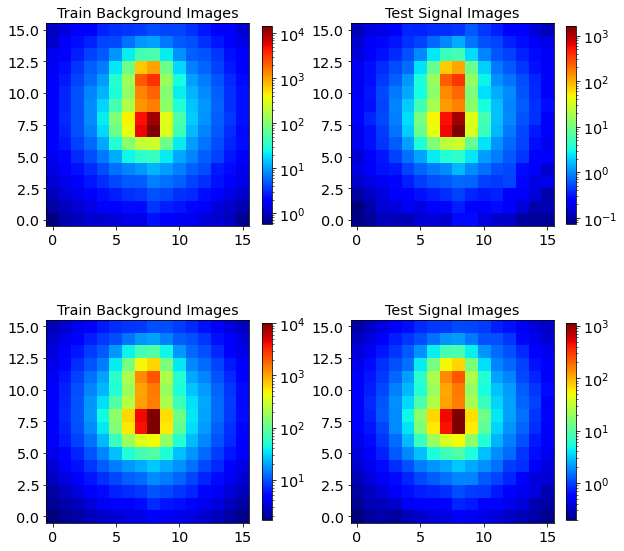

In [20]:
#plot train and test signal
sig_train_images = np.sum(data_train['jetImages'][ind_train_sig],axis=0).reshape(grid,grid)
sig_test_images = np.sum(data_test['jetImages'][ind_test_sig],axis=0).reshape(grid,grid)
bkg_train_images = np.sum(data_train['jetImages'][ind_train_bkg],axis=0).reshape(grid,grid)
bkg_test_images = np.sum(data_test['jetImages'][ind_test_bkg],axis=0).reshape(grid,grid)

# Build figure with train and test set 
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
im0 = ax[0][0].imshow(sig_train_images,
                      interpolation='nearest',
                      origin='low',
                      cmap = 'jet',
                      norm=LogNorm())
ax[0][0].set_title('Train Background Images')
fig.colorbar(im0, shrink=0.8, ax=ax[0][0])
im1 = ax[0][1].imshow(sig_test_images,
                      interpolation='nearest',
                      origin='low',
                      cmap = 'jet',
                      norm=LogNorm())
ax[0][1].set_title('Test Signal Images')
fig.colorbar(im1,shrink=0.8, ax=ax[0][1])
im2 = ax[1][0].imshow(bkg_train_images,
                      interpolation='nearest',
                      origin='low',
                      cmap = 'jet',
                      norm=LogNorm())
ax[1][0].set_title('Train Background Images')
fig.colorbar(im2, shrink=0.8, ax=ax[1][0])
im3 = ax[1][1].imshow(bkg_test_images, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
ax[1][1].set_title('Test Signal Images')
fig.colorbar(im3,shrink=0.8, ax=ax[1][1])
#plt.show()
plt.savefig('plots/jet_images.pdf')

### jetPt

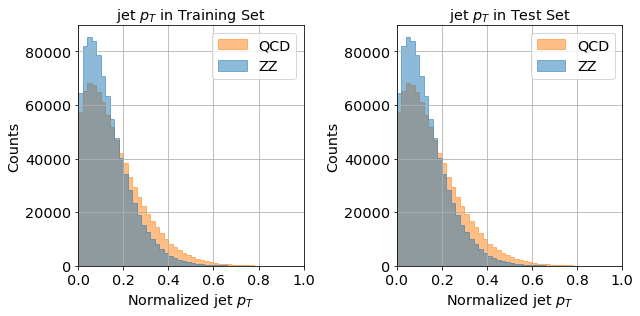

In [21]:
Draw_HistoGram('jetPt',50)

### jetEta

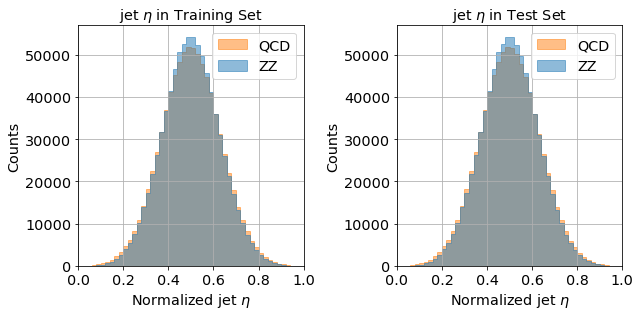

In [22]:
Draw_HistoGram('jetEta',50)

### jetPhi

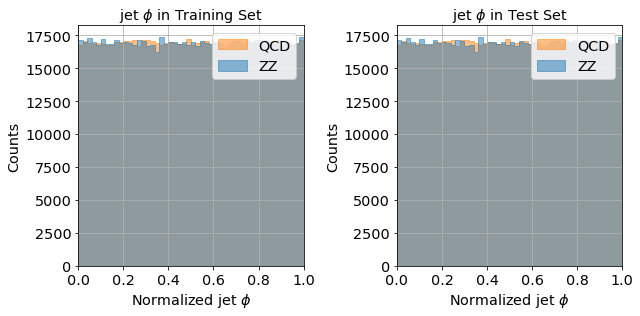

In [23]:
Draw_HistoGram('jetPhi',50)

### tau21

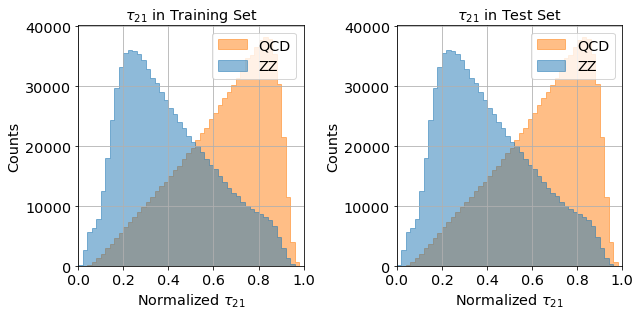

In [24]:
Draw_HistoGram('tau21',50)

### charge Multiplicity

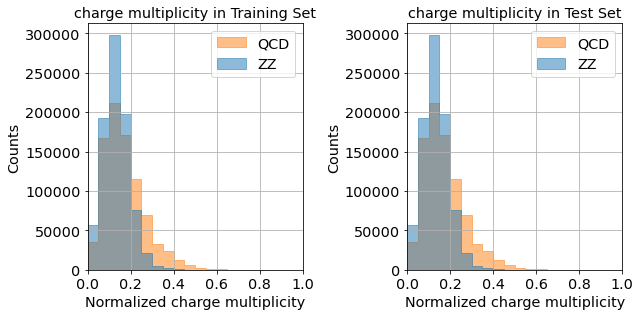

In [25]:
Draw_HistoGram('chMult',20)

### neutral Multiplicity

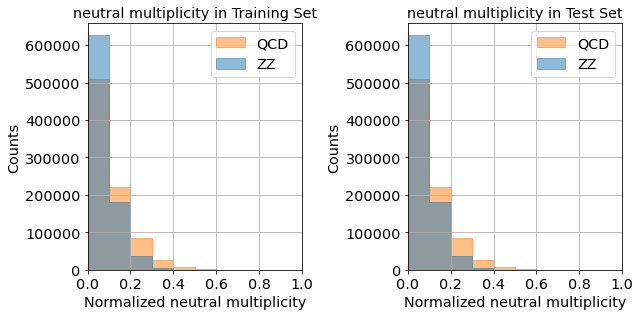

In [26]:
Draw_HistoGram('neutMult',10)

### photon Multiplicity

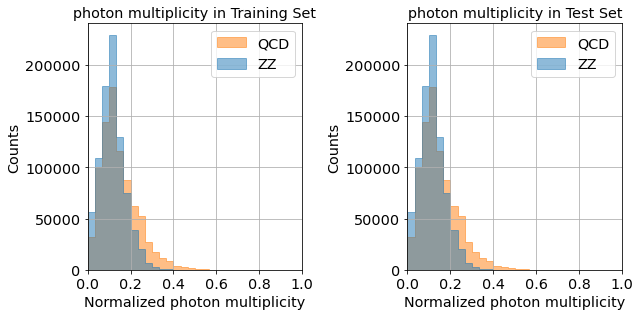

In [27]:
Draw_HistoGram('phoMult',30)

### electron Multiplicity

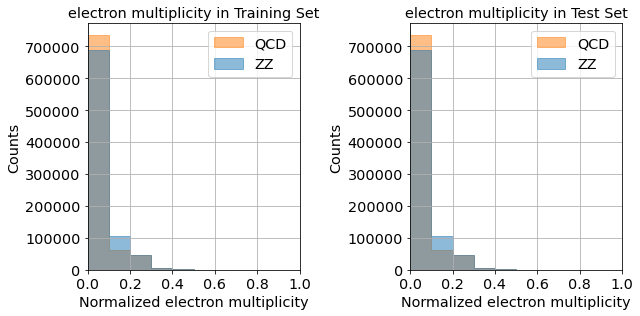

In [28]:
Draw_HistoGram('eleMult',10)

### muon Mult

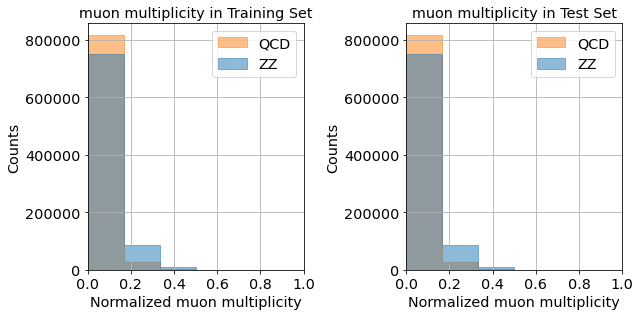

In [29]:
Draw_HistoGram('muMult',6)

### jetpull

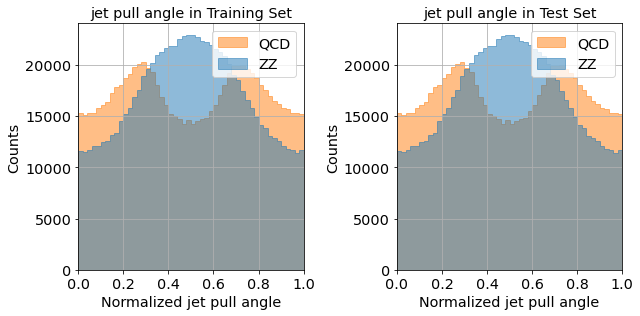

In [30]:
Draw_HistoGram('jetpull',50)

## Save Test and Train Data

In [31]:
np.savez('../data/ShowJet_full_train.npz',**data_train)
np.savez('../data/ShowJet_full_test.npz',**data_test)